<a href="https://colab.research.google.com/github/KMISchool2022/mlFit/blob/main/mlFit.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
</a>

In [15]:
# Example of maximum-likelihood fit with iminuit version 2.
# pdf is a mixture of Gaussian (signal) and exponential (background),
# truncated in [xMin,xMax].
# G. Cowan / RHUL Physics / December 2022

import numpy as np
import scipy.stats as stats
from scipy.stats import truncexpon
from scipy.stats import truncnorm
from scipy.stats import chi2
from scipy.stats import norm
import iminuit
from iminuit import Minuit
import matplotlib.pyplot as plt
from matplotlib import container
plt.rcParams["font.size"] = 14
print("iminuit version:", iminuit.__version__)  # need 2.x

iminuit version: 2.30.1


In [16]:
# define pdf and generate data
np.random.seed(seed=1234567)        # fix random seed
theta = 0.2                         # fraction of signal
mu = 10.                            # mean of Gaussian
sigma = 2.                          # std. dev. of Gaussian
xi = 5.                             # mean of exponential
xMin = 0.
xMax = 20.

def f(x, par):
    theta   = par[0]
    mu      = par[1]
    sigma   = par[2]
    xi      = par[3]
    fs = stats.truncnorm.pdf(x, a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
    fb = stats.truncexpon.pdf(x, b=(xMax-xMin)/xi, loc=xMin, scale=xi)
    return theta*fs + (1-theta)*fb
        
numVal = 200
xData = np.empty([numVal])  
for i in range (numVal):
    r = np.random.uniform();
    if r < theta:
        xData[i] = stats.truncnorm.rvs(a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
    else:
        xData[i] = stats.truncexpon.rvs(b=(xMax-xMin)/xi, loc=xMin, scale=xi)

In [17]:
# xData

In [18]:
type(xData)

numpy.ndarray

(array([18., 10.,  9.,  5., 10.,  5.,  7.,  5.,  7.,  6.,  5.,  6.,  2.,
         6., 12.,  4.,  4.,  3.,  3.,  6.,  3.,  6.,  8.,  4.,  6.,  3.,
         4.,  5.,  4.,  4.,  3.,  2.,  2.,  2.,  2.,  1.,  2.,  1.,  1.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  2.]),
 array([5.16384023e-03, 3.90515933e-01, 7.75868027e-01, 1.16122012e+00,
        1.54657221e+00, 1.93192431e+00, 2.31727640e+00, 2.70262849e+00,
        3.08798059e+00, 3.47333268e+00, 3.85868477e+00, 4.24403687e+00,
        4.62938896e+00, 5.01474105e+00, 5.40009315e+00, 5.78544524e+00,
        6.17079733e+00, 6.55614943e+00, 6.94150152e+00, 7.32685361e+00,
        7.71220570e+00, 8.09755780e+00, 8.48290989e+00, 8.86826198e+00,
        9.25361408e+00, 9.63896617e+00, 1.00243183e+01, 1.04096704e+01,
        1.07950225e+01, 1.11803745e+01, 1.15657266e+01, 1.19510787e+01,
        1.23364308e+01, 1.27217829e+01, 1.31071350e+01, 1.34924871e+01,
        1.38778392e+01, 1.42631913e+01, 1.46485434e+01, 1.50338955e+

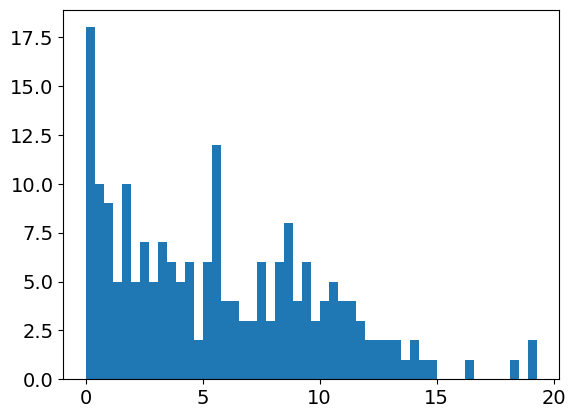

In [19]:
plt.hist(xData,bins=50)

In [20]:
# par

In [21]:
# Function to be minimized is negative log-likelihood
def negLogL(par):
    pdf = f(xData, par)
    return -np.sum(np.log(pdf)) 

In [22]:
# Initialize Minuit and set up fit:
# parin   = np.array([theta, mu, sigma, xi]) # initial values (here = true values)
parin = np.array([0.01,10, 2, 20])
parname = ['theta', 'mu', 'sigma', 'xi']
parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma$', r'$\xi$']
parstep = np.array([0.1, 1., 1., 1.])      # initial setp sizes
parfix  = [False, True, True, False]       # change these to fix/free parameters
parlim  = [(0.,1), (None, None), (0., None), (0., None)]    # set limits
m = Minuit(negLogL, parin, name=parname)
m.errors = parstep
m.fixed = parfix
m.limits = parlim
m.errordef = 0.5                           # errors from lnL = lnLmax - 0.5

In [23]:
# Do the fit, get errors, extract results
m.migrad()                                        # minimize -logL
MLE = m.values                                    # max-likelihood estimates
sigmaMLE = m.errors                               # standard deviations
cov = m.covariance                                # covariance matrix
rho = m.covariance.correlation()                  # correlation coeffs.
    
print(r"par index, name, estimate, standard deviation:")
for i in range(m.npar):
    if not m.fixed[i]:
        print("{:4d}".format(i), "{:<10s}".format(m.parameters[i]), " = ",
         "{:.6f}".format(MLE[i]), " +/- ", "{:.6f}".format(sigmaMLE[i]))

print()
print(r"free par indices, covariance, correlation coeff.:")
for i in range(m.npar):
    if not(m.fixed[i]):
        for j in range(m.npar):
            if not(m.fixed[j]):
                print(i, j, "{:.6f}".format(cov[i,j]), "{:.6f}".format(rho[i,j]))

par index, name, estimate, standard deviation:
   0 theta       =  0.204588  +/-  0.052735
   3 xi          =  5.107985  +/-  0.644614

free par indices, covariance, correlation coeff.:
0 0 0.002797 1.000000
0 3 -0.018131 -0.531737
3 0 -0.018131 -0.531737
3 3 0.415657 1.000000


In [24]:
MLE

<ValueView theta=0.20458796443144034 mu=10.0 sigma=2.0 xi=5.107984503368879>

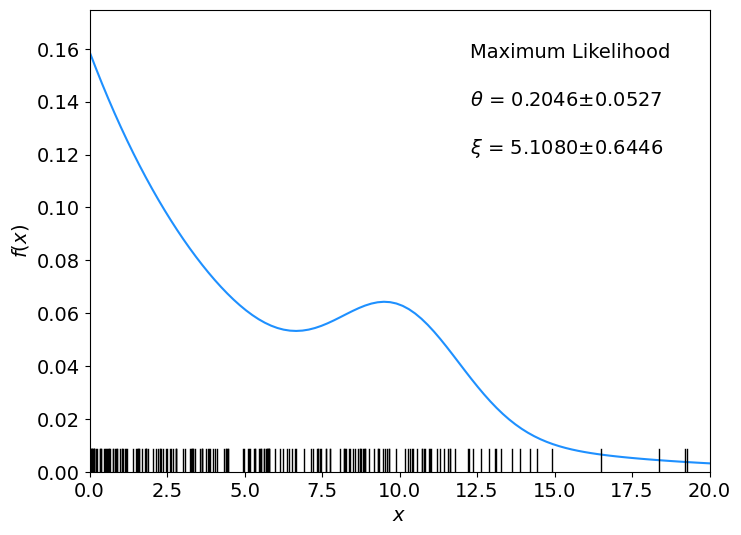

In [25]:
# Plot fitted pdf
yMin = 0.
yMax = f(0., MLE)*1.1
fig = plt.figure(figsize=(8,6))
xCurve = np.linspace(xMin, xMax, 100)
yCurve = f(xCurve, MLE)
plt.plot(xCurve, yCurve, color='dodgerblue')
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
y_fitval = 0.8
delta_y_fitval = 0.08
plt.figtext(0.6, y_fitval, 'Maximum Likelihood')
for i in range(len(parin)):
    if not parfix[i]:
        y_fitval -= delta_y_fitval
        plt.figtext(0.6, y_fitval, parname_latex[i] + ' = ' + f'{MLE[i]:.4f}' + r'$\pm$' + f'{sigmaMLE[i]:.4f}')
        
# Plot data as tick marks
tick_height = 0.05*(yMax - yMin)
xvals = [xData, xData]
yvals = [np.zeros_like(xData), tick_height * np.ones_like(xData)]
plt.plot(xvals, yvals, color='black', linewidth=1)
plt.xlim(xMin, xMax)
plt.ylim(yMin, yMax)

plt.show()

In [26]:
# x1=[[1,2],[2,3]]
# y1=[[0,0],[4,5]]

# plt.plot(x1,y1)
# plt.show()

In [27]:
# xvals


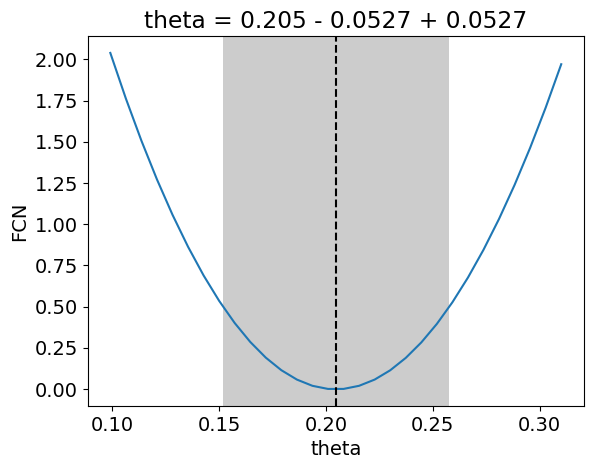

In [28]:
# Make scan of lnL (for theta, if free)
if not(m.fixed['theta']):
    plt.figure()
    m.draw_mnprofile('theta')
    plt.show()

CL =  0.3934693402873665


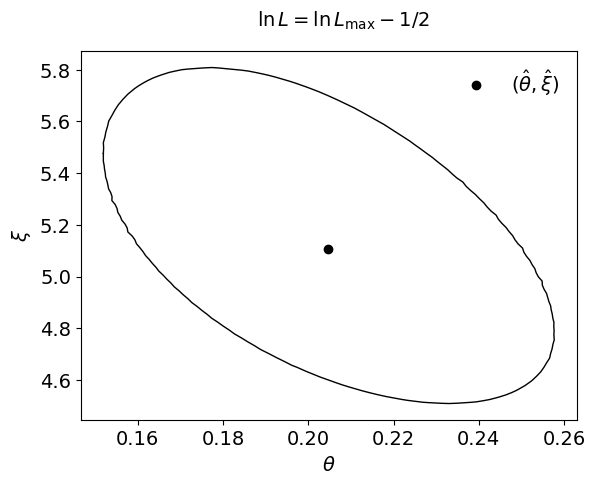

In [29]:
# Make a contour plot of lnL = lnLmax - 1/2 (here for theta and xi).
# The tangents to this contour give the standard deviations.
CL = stats.chi2.cdf(1.,2)           #  Q_alpha = 1, npar = 2
print('CL = ', CL)
if not(m.fixed['theta'] | m.fixed['xi']):
    fig, ax = plt.subplots(1,1)
    con = m.mncontour('theta', 'xi', cl=CL, size=200)
    con = np.vstack([con, con[0]])         # close contour
    plt.plot(MLE[0], MLE[3], marker='o', linestyle='None', color='black', label=r'$(\hat{\theta}, \hat{\xi})$')
    plt.plot(con[:,0], con[:,1], color='black', linewidth=1)
    plt.xlabel(r'$\theta$', labelpad=5)
    plt.ylabel(r'$\xi$', labelpad=5)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right', fontsize=14, frameon=False)
    plt.figtext(0.4, 0.93, r'$\ln L = \ln L_{\rm max} - 1/2$')
    plt.show()

In [30]:
con.shape

(202, 2)

In [31]:
# con

In [32]:
# con[:,0]
# con[:,1]

In [33]:
MLE[3]

5.107984503368879

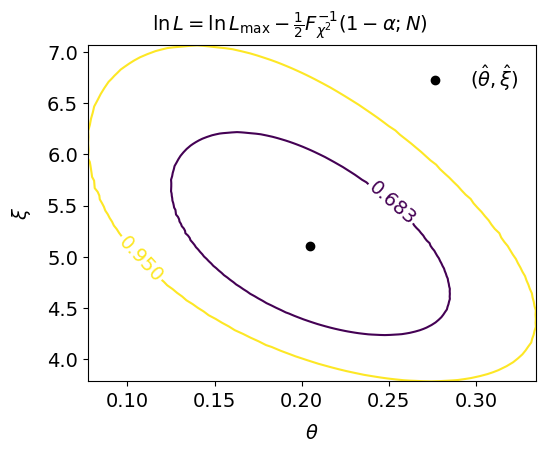

In [34]:
# Confidence region from lnL = lnLmax - Q/2 (here for theta and xi)
# where Q is the chi2 quantile of CL = 1-alpha = 0.683 and 0.95 for 2 dof.
if not(m.fixed['theta'] | m.fixed['xi']):
    fig, ax = plt.subplots(1,1)
    m.draw_mncontour('theta', 'xi', cl=[0.683, 0.95], size=200);
    plt.plot(MLE[0], MLE[3], marker='o', linestyle='None', color='black', label=r'$(\hat{\theta}, \hat{\xi})$')
    plt.xlabel(r'$\theta$', labelpad=10)
    plt.ylabel(r'$\xi$', labelpad=10)
    plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.2)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right', fontsize=14, frameon=False)
    plt.figtext(0.3, 0.93, r'$\ln L = \ln L_{\rm max} - \frac{1}{2} F^{-1}_{\chi^2}(1-\alpha;N)$')
    plt.show()

In [35]:
theta_max=max(con[:,0])
theta_min=min(con[:,0])
xi_max=max(con[:,1])
xi_min=min(con[:,1])

In [36]:
theta_std=theta_max-theta_min
theta_std/2
xi_std=xi_max-xi_min
xi_std/2

0.6497666692082023

In [37]:
numVal_list = [100,200,400,800]

sigma_theta_list = []

for n in numVal_list:

    np.random.seed(seed=1234567)        # fix random seed
    theta = 0.2                         # fraction of signal
    mu = 10.                            # mean of Gaussian
    sigma = 2.                          # std. dev. of Gaussian
    xi = 5.                             # mean of exponential
    xMin = 0.
    xMax = 20.

    def f(x, par):
        theta   = par[0]
        mu      = par[1]
        sigma   = par[2]
        xi      = par[3]
        fs = stats.truncnorm.pdf(x, a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
        fb = stats.truncexpon.pdf(x, b=(xMax-xMin)/xi, loc=xMin, scale=xi)
        return theta*fs + (1-theta)*fb
            
    numVal = 200
    xData = np.empty([n])  
    for i in range (n):
        r = np.random.uniform();
        if r < theta:
            xData[i] = stats.truncnorm.rvs(a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
        else:
            xData[i] = stats.truncexpon.rvs(b=(xMax-xMin)/xi, loc=xMin, scale=xi)

    # Initialize Minuit and set up fit:
    parin   = np.array([theta, mu, sigma, xi]) # initial values (here = true values)
    parname = ['theta', 'mu', 'sigma', 'xi']
    parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma$', r'$\xi$']
    parstep = np.array([0.1, 1., 1., 1.])      # initial setp sizes
    parfix  = [False, True, True, False]       # change these to fix/free parameters
    parlim  = [(0.,1), (None, None), (0., None), (0., None)]    # set limits
    m = Minuit(negLogL, parin, name=parname)
    m.errors = parstep
    m.fixed = parfix
    m.limits = parlim
    m.errordef = 0.5                           # errors from lnL = lnLmax - 0.5


    m.migrad()                                        # minimize -logL
    m.parameters[3]
    sigmaMLE = m.errors
    sigma_theta_list.append(sigmaMLE[0])
    

In [38]:
sigma_theta_list

[0.0712192785618411,
 0.05273589908488055,
 0.03698544410704657,
 0.026128803640034726]

Text(0, 0.5, 'Standard deviation $\\sigma_{\\hat{\\theta}}$')

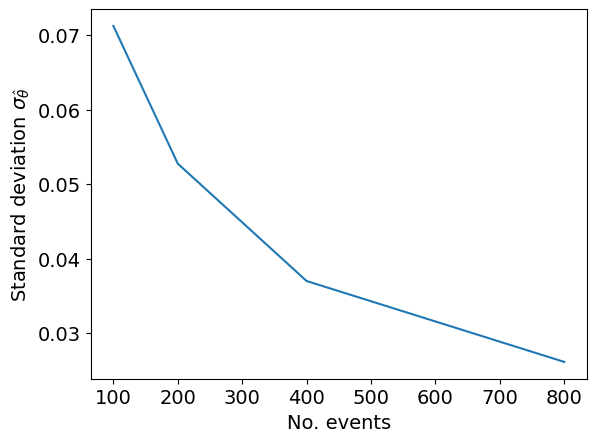

In [39]:
plt.plot(numVal_list, sigma_theta_list)
plt.xlabel('No. events')
plt.ylabel(r'Standard deviation $\sigma_{\hat{\theta}}$')

In [40]:
parfix_list = [[False,True,True,True],[False,True,True,False],[False,True,False,False],[False,False,False,False]]

sigma_theta_list = []
theta_list=[]
n=200
for parfix in parfix_list:

    np.random.seed(seed=1234567)        # fix random seed
    theta = 0.2                         # fraction of signal
    mu = 10.                            # mean of Gaussian
    sigma = 2.                          # std. dev. of Gaussian
    xi = 5.                             # mean of exponential
    xMin = 0.
    xMax = 20.

    def f(x, par):
        theta   = par[0]
        mu      = par[1]
        sigma   = par[2]
        xi      = par[3]
        fs = stats.truncnorm.pdf(x, a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
        fb = stats.truncexpon.pdf(x, b=(xMax-xMin)/xi, loc=xMin, scale=xi)
        return theta*fs + (1-theta)*fb
            
    numVal = 200
    xData = np.empty([n])  
    for i in range (n):
        r = np.random.uniform();
        if r < theta:
            xData[i] = stats.truncnorm.rvs(a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
        else:
            xData[i] = stats.truncexpon.rvs(b=(xMax-xMin)/xi, loc=xMin, scale=xi)

    # Initialize Minuit and set up fit:
    parin   = np.array([theta, mu, sigma, xi]) # initial values (here = true values)
    parname = ['theta', 'mu', 'sigma', 'xi']
    parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma$', r'$\xi$']
    parstep = np.array([0.1, 1., 1., 1.])      # initial setp sizes
    parfixx  =  parfix      # change these to fix/free parameters
    parlim  = [(0.,1), (None, None), (0., None), (0., None)]    # set limits
    m = Minuit(negLogL, parin, name=parname)
    m.errors = parstep
    m.fixed = parfixx
    m.limits = parlim
    m.errordef = 0.5                           # errors from lnL = lnLmax - 0.5


    m.migrad() 
    MLE = m.values                                       # minimize -logL
    m.parameters[3]
    sigmaMLE = m.errors
    sigma_theta_list.append(sigmaMLE[0])
    theta_list.append(MLE[0])


In [41]:
sigma_theta_list

[0.04453454997392922,
 0.05273589908488055,
 0.06445629035671242,
 0.08578617243590424]

In [42]:
theta_list

[0.20951598690022014,
 0.20455124650334994,
 0.2119863590443255,
 0.260567000224867]

In [43]:
# define pdf and generate data
np.random.seed(seed=1234567)        # fix random seed
theta = 0.2                         # fraction of signal
mu = 10.                            # mean of Gaussian
sigma = 2.                          # std. dev. of Gaussian
xi = 5.                             # mean of exponential
xMin = 0.
xMax = 20.

def f(x, par):
    theta   = par[0]
    mu      = par[1]
    sigma   = par[2]
    xi      = par[3]
    fs = stats.truncnorm.pdf(x, a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
    fb = stats.truncexpon.pdf(x, b=(xMax-xMin)/xi, loc=xMin, scale=xi)
    return theta*fs + (1-theta)*fb
        
numVal = 200
xData = np.empty([numVal])  
for i in range (numVal):
    r = np.random.uniform();
    if r < theta:
        xData[i] = stats.truncnorm.rvs(a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
    else:
        xData[i] = stats.truncexpon.rvs(b=(xMax-xMin)/xi, loc=xMin, scale=xi)

In [44]:
# define pdf and generate data                                 

def f_G(x, par):
    sigma   = 0.5
    xi      = par[3]
    norm_dist = norm.pdf(x, xi, sigma)
    return norm_dist
        
# numVal = 200
xData_gauss = 5  

In [45]:
# Function to be minimized is negative log-likelihood
def negLogL(par):
    pdf = f(xData, par)*f_G(xData_gauss,par)
    return -np.sum(np.log(pdf))

In [46]:
# Initialize Minuit and set up fit:
parin   = np.array([theta, mu, sigma, xi]) # initial values (here = true values)
parname = ['theta', 'mu', 'sigma', 'xi']
parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma$', r'$\xi$']
parstep = np.array([0.1, 1., 1., 1.])      # initial setp sizes
parfix  = [False, True, True, False]       # change these to fix/free parameters
parlim  = [(0.,1), (None, None), (0., None), (0., None)]    # set limits
m = Minuit(negLogL, parin, name=parname)
m.errors = parstep
m.fixed = parfix
m.limits = parlim
m.errordef = 0.5                           # errors from lnL = lnLmax - 0.5

In [47]:
# Do the fit, get errors, extract results
m.migrad()                                        # minimize -logL
MLE = m.values                                    # max-likelihood estimates
sigmaMLE = m.errors                               # standard deviations
cov = m.covariance                                # covariance matrix
rho = m.covariance.correlation()                  # correlation coeffs.
    
print(r"par index, name, estimate, standard deviation:")
for i in range(m.npar):
    if not m.fixed[i]:
        print("{:4d}".format(i), "{:<10s}".format(m.parameters[i]), " = ",
         "{:.6f}".format(MLE[i]), " +/- ", "{:.6f}".format(sigmaMLE[i]))

print()
print(r"free par indices, covariance, correlation coeff.:")
for i in range(m.npar):
    if not(m.fixed[i]):
        for j in range(m.npar):
            if not(m.fixed[j]):
                print(i, j, "{:.6f}".format(cov[i,j]), "{:.6f}".format(rho[i,j]))

par index, name, estimate, standard deviation:
   0 theta       =  0.209516  +/-  0.044564
   3 xi          =  5.000606  +/-  0.035298

free par indices, covariance, correlation coeff.:
0 0 0.001994 1.000000
0 3 -0.000056 -0.035578
3 0 -0.000056 -0.035578
3 3 0.001246 1.000000
